In [46]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import re
from collections import defaultdict

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")


Libraries imported successfully!


In [47]:
def parse_filename(filename):
    """Parse metrics filename to extract hyperparameters"""
    # Pattern: test_qwen25-math-cot_-1_seed0_t0.0_top_k{K}_enable_thinking{THINKING}_s0_e-1_qwen25-math-cot_metrics.json
    pattern = r'test_qwen25-math-cot_-1_seed0_t0\.0_top_k(\d+)_enable_thinking(True|False)_s0_e-1_qwen25-math-cot_metrics\.json'
    match = re.match(pattern, filename)
    if match:
        return {
            'top_k': int(match.group(1)),
            'enable_thinking': match.group(2) == 'True'
        }
    return None

def extract_checkpoint_from_path(path):
    """Extract checkpoint number from directory path"""
    if 'thinking_checkpoint' in path:
        match = re.search(r'thinking_checkpoint(\d+)', path)
        return int(match.group(1)) if match else None
    elif 'checkpoint' in path:
        match = re.search(r'checkpoint(\d+)', path)
        return int(match.group(1)) if match else None
    return None

def extract_max_tokens_from_path(path):
    """Extract max_tokens_per_call from directory path"""
    match = re.search(r'max_tokens_per_call(\d+)', path)
    return int(match.group(1)) if match else None

def compile_results(base_dir):
    """Compile all evaluation results from the outputs directory"""
    results = []
    base_path = Path(base_dir)
    
    for output_dir in base_path.iterdir():
        if not output_dir.is_dir():
            continue
            
        # Extract checkpoint and max_tokens from directory name
        checkpoint = extract_checkpoint_from_path(str(output_dir))
        max_tokens = extract_max_tokens_from_path(str(output_dir))
        is_thinking_mode = 'thinking_checkpoint' in str(output_dir)
        
        # Look for math500 subdirectory
        math500_dir = output_dir / 'math500'
        if not math500_dir.exists():
            continue
            
        # Find all metrics files
        for metrics_file in math500_dir.glob('*_metrics.json'):
            # Parse filename to get hyperparameters
            params = parse_filename(metrics_file.name)
            if params is None:
                continue
                
            # Load metrics
            try:
                with open(metrics_file, 'r') as f:
                    metrics = json.load(f)
                
                # Combine all information
                result = {
                    'checkpoint': checkpoint,
                    'max_tokens_per_call': max_tokens,
                    'is_thinking_mode': is_thinking_mode,
                    'top_k': params['top_k'],
                    'enable_thinking': params['enable_thinking'],
                    'accuracy': metrics['acc'],
                    'num_samples': metrics['num_samples'],
                    'num_scores': metrics['num_scores'],
                    'timeout_samples': metrics['timeout_samples'],
                    'empty_samples': metrics['empty_samples'],
                    'time_seconds': metrics['time_use_in_second'],
                    'time_minutes': metrics['time_use_in_minite'],
                    'file_path': str(metrics_file)
                }
                results.append(result)
                
            except (json.JSONDecodeError, KeyError) as e:
                print(f"Error reading {metrics_file}: {e}")
                continue
    
    return pd.DataFrame(results)

# Compile all results
output_base_dir = "experiments/02_evaluation/outputs"
df = compile_results(output_base_dir)

print(f"Compiled {len(df)} results")
print(f"Columns: {list(df.columns)}")
print(f"\nSample of data:")
print(df.head())


Compiled 77 results
Columns: ['checkpoint', 'max_tokens_per_call', 'is_thinking_mode', 'top_k', 'enable_thinking', 'accuracy', 'num_samples', 'num_scores', 'timeout_samples', 'empty_samples', 'time_seconds', 'time_minutes', 'file_path']

Sample of data:
   checkpoint  max_tokens_per_call  is_thinking_mode  top_k  enable_thinking  \
0         100                32000             False      1            False   
1         100                32000             False      4            False   
2         100                32000             False     20            False   
3         100                32000             False      2            False   
4         100                32000             False     24            False   

   accuracy  num_samples  num_scores  timeout_samples  empty_samples  \
0       0.4          500         500                0              4   
1      85.8          500         500                0              3   
2      64.8          500         500             

In [4]:
# Data exploration and summary statistics
print("=== DATA OVERVIEW ===")
print(f"Total experiments: {len(df)}")
print(f"Unique checkpoints: {sorted(df['checkpoint'].unique())}")
print(f"Unique max_tokens_per_call: {sorted(df['max_tokens_per_call'].unique())}")
print(f"Unique top_k values: {sorted(df['top_k'].unique())}")
print(f"Thinking mode experiments: {df['is_thinking_mode'].sum()}")
print(f"Non-thinking mode experiments: {(~df['is_thinking_mode']).sum()}")

print("\n=== ACCURACY STATISTICS ===")
print(df['accuracy'].describe())

print("\n=== MISSING DATA ===")
print(df.isnull().sum())

print("\n=== SAMPLE DATA ===")
print(df.head(10))


=== DATA OVERVIEW ===
Total experiments: 47
Unique checkpoints: [100, 500, 1000]
Unique max_tokens_per_call: [4096, 32000]
Unique top_k values: [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
Thinking mode experiments: 0
Non-thinking mode experiments: 47

=== ACCURACY STATISTICS ===
count    47.000000
mean     66.217021
std      25.618364
min       0.400000
25%      58.500000
50%      71.400000
75%      87.800000
max      90.800000
Name: accuracy, dtype: float64

=== MISSING DATA ===
checkpoint             0
max_tokens_per_call    0
is_thinking_mode       0
top_k                  0
enable_thinking        0
accuracy               0
num_samples            0
num_scores             0
timeout_samples        0
empty_samples          0
time_seconds           0
time_minutes           0
file_path              0
dtype: int64

=== SAMPLE DATA ===
   checkpoint  max_tokens_per_call  is_thinking_mode  top_k  enable_thinking  \
0         100                32000             False      1            False   
1  

In [7]:
# Print accuracy tables for each checkpoint and max_tokens_per_call combination
print("=== ACCURACY TABLES BY CHECKPOINT AND MAX_TOKENS_PER_CALL ===\n")

for checkpoint in sorted(df['checkpoint'].unique()):
    print(f"CHECKPOINT {checkpoint}")
    print("=" * 50)
    
    checkpoint_data = df[df['checkpoint'] == checkpoint]
    
    for max_tokens in sorted(checkpoint_data['max_tokens_per_call'].unique()):
        print(f"\nMax Tokens Per Call: {max_tokens}")
        print("-" * 30)
        
        subset = checkpoint_data[checkpoint_data['max_tokens_per_call'] == max_tokens]
        
        if len(subset) > 0:
            # Create a table with top_k as index and accuracy as values
            accuracy_table = subset.set_index('top_k')['accuracy'].sort_index()
            
            print("Top-K | Accuracy (%)")
            print("------|------------")
            for top_k, accuracy in accuracy_table.items():
                print(f"{top_k:5d} | {accuracy:10.1f}")
        else:
            print("No data available")
    
    print("\n" + "=" * 70 + "\n")


=== ACCURACY TABLES BY CHECKPOINT AND MAX_TOKENS_PER_CALL ===

CHECKPOINT 100

Max Tokens Per Call: 4096
------------------------------
Top-K | Accuracy (%)
------|------------
    1 |        1.0
    4 |       45.8
    8 |       57.8
   16 |       58.0
   24 |       51.8
   28 |       49.4
   32 |       45.0

Max Tokens Per Call: 32000
------------------------------
Top-K | Accuracy (%)
------|------------
    1 |        0.4
    2 |        4.6
    4 |       85.8
    8 |       89.6
   12 |       84.0
   20 |       64.8
   24 |       59.0


CHECKPOINT 500

Max Tokens Per Call: 4096
------------------------------
Top-K | Accuracy (%)
------|------------
    2 |       40.4
    4 |       60.8
    8 |       66.8
   12 |       66.6
   16 |       69.0
   20 |       72.8
   24 |       74.4
   32 |       73.8

Max Tokens Per Call: 32000
------------------------------
Top-K | Accuracy (%)
------|------------
    1 |        3.4
    4 |       88.2
    8 |       89.4
   12 |       89.6
   20 |      

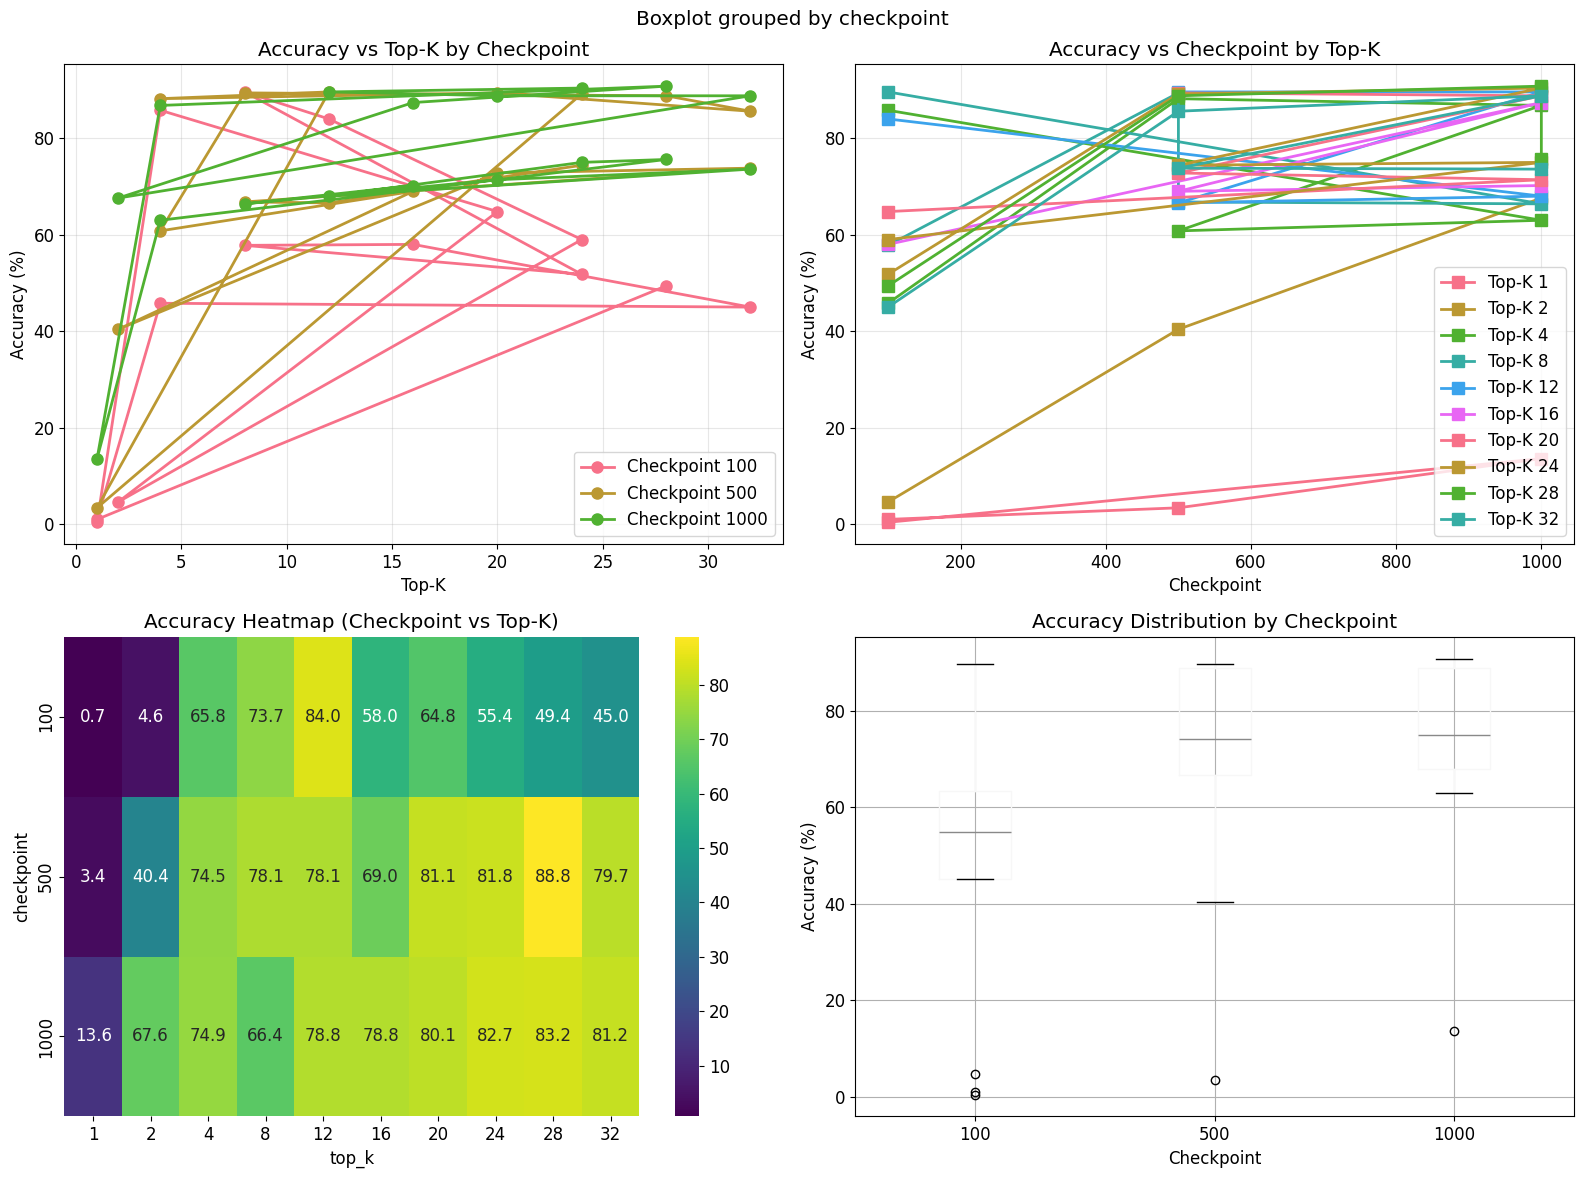

In [5]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy vs Top-K for different checkpoints
ax1 = axes[0, 0]
for checkpoint in sorted(df['checkpoint'].unique()):
    checkpoint_data = df[df['checkpoint'] == checkpoint]
    ax1.plot(checkpoint_data['top_k'], checkpoint_data['accuracy'], 
             marker='o', label=f'Checkpoint {checkpoint}', linewidth=2, markersize=8)
ax1.set_xlabel('Top-K')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy vs Top-K by Checkpoint')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Accuracy vs Checkpoint for different Top-K values
ax2 = axes[0, 1]
for top_k in sorted(df['top_k'].unique()):
    top_k_data = df[df['top_k'] == top_k]
    ax2.plot(top_k_data['checkpoint'], top_k_data['accuracy'], 
             marker='s', label=f'Top-K {top_k}', linewidth=2, markersize=8)
ax2.set_xlabel('Checkpoint')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy vs Checkpoint by Top-K')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Heatmap of accuracy by checkpoint and top_k
ax3 = axes[1, 0]
pivot_table = df.pivot_table(values='accuracy', index='checkpoint', columns='top_k', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='viridis', ax=ax3)
ax3.set_title('Accuracy Heatmap (Checkpoint vs Top-K)')

# 4. Box plot of accuracy distribution by checkpoint
ax4 = axes[1, 1]
df.boxplot(column='accuracy', by='checkpoint', ax=ax4)
ax4.set_title('Accuracy Distribution by Checkpoint')
ax4.set_xlabel('Checkpoint')
ax4.set_ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()


In [ ]:
# Performance analysis
print("=== BEST PERFORMING CONFIGURATIONS ===")
best_configs = df.nlargest(10, 'accuracy')[['checkpoint', 'top_k', 'max_tokens_per_call', 'accuracy', 'time_seconds']]
print(best_configs)

print("\n=== WORST PERFORMING CONFIGURATIONS ===")
worst_configs = df.nsmallest(10, 'accuracy')[['checkpoint', 'top_k', 'max_tokens_per_call', 'accuracy', 'time_seconds']]
print(worst_configs)

print("\n=== AVERAGE ACCURACY BY CHECKPOINT ===")
checkpoint_avg = df.groupby('checkpoint')['accuracy'].agg(['mean', 'std', 'count']).round(2)
print(checkpoint_avg)

print("\n=== AVERAGE ACCURACY BY TOP_K ===")
top_k_avg = df.groupby('top_k')['accuracy'].agg(['mean', 'std', 'count']).round(2)
print(top_k_avg)

print("\n=== AVERAGE ACCURACY BY MAX_TOKENS_PER_CALL ===")
max_tokens_avg = df.groupby('max_tokens_per_call')['accuracy'].agg(['mean', 'std', 'count']).round(2)
print(max_tokens_avg)


In [ ]:
# Time analysis
print("=== TIME ANALYSIS ===")
df['time_hours'] = df['time_seconds'] / 3600

# Time vs accuracy scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['time_hours'], df['accuracy'], 
                     c=df['top_k'], s=100, alpha=0.7, cmap='viridis')
plt.colorbar(scatter, label='Top-K')
plt.xlabel('Time (hours)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Time by Top-K')
plt.grid(True, alpha=0.3)

# Add annotations for extreme points
for idx, row in df.iterrows():
    if row['accuracy'] > df['accuracy'].quantile(0.9) or row['time_hours'] > df['time_hours'].quantile(0.9):
        plt.annotate(f"CP{row['checkpoint']}_K{row['top_k']}", 
                    (row['time_hours'], row['accuracy']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.show()

print("\n=== TIME STATISTICS ===")
print(f"Average time: {df['time_hours'].mean():.2f} hours")
print(f"Median time: {df['time_hours'].median():.2f} hours")
print(f"Min time: {df['time_hours'].min():.2f} hours")
print(f"Max time: {df['time_hours'].max():.2f} hours")


In [ ]:
# Export results
print("=== EXPORTING RESULTS ===")

# Save comprehensive results
df.to_csv('experiments/02_evaluation/compiled_results.csv', index=False)
print("✓ Saved compiled_results.csv")

# Save summary statistics
summary_stats = {
    'total_experiments': len(df),
    'best_accuracy': df['accuracy'].max(),
    'worst_accuracy': df['accuracy'].min(),
    'average_accuracy': df['accuracy'].mean(),
    'checkpoints': sorted(df['checkpoint'].unique()),
    'top_k_values': sorted(df['top_k'].unique()),
    'max_tokens_values': sorted(df['max_tokens_per_call'].unique()),
}

with open('experiments/02_evaluation/summary_stats.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
print("✓ Saved summary_stats.json")

# Create a pivot table for easy viewing
pivot_df = df.pivot_table(
    values='accuracy', 
    index=['checkpoint', 'max_tokens_per_call'], 
    columns='top_k', 
    aggfunc='mean'
).round(1)

pivot_df.to_csv('experiments/02_evaluation/accuracy_pivot.csv')
print("✓ Saved accuracy_pivot.csv")
print("\nPivot table preview:")
print(pivot_df)

print(f"\n=== SUMMARY ===")
print(f"Best configuration: Checkpoint {df.loc[df['accuracy'].idxmax(), 'checkpoint']}, "
      f"Top-K {df.loc[df['accuracy'].idxmax(), 'top_k']}, "
      f"Max tokens {df.loc[df['accuracy'].idxmax(), 'max_tokens_per_call']}")
print(f"Best accuracy: {df['accuracy'].max():.1f}%")
print(f"Average accuracy: {df['accuracy'].mean():.1f}%")
print(f"Total experiments: {len(df)}")


In [50]:
import json
import pandas as pd
filename_2 = "/home/rishabhtiwari/repos/01_META_REASONING_MOE/experiments/02_evaluation/outputs/checkpoint1000_max_tokens_per_call4096/math500/test_qwen25-math-cot_-1_seed0_t0.0_top_k8_enable_thinkingFalse_s0_e-1.jsonl"
filename_8 = "/home/rishabhtiwari/repos/01_META_REASONING_MOE/experiments/02_evaluation/outputs/checkpoint1000_max_tokens_per_call32000/math500/test_qwen25-math-cot_-1_seed0_t0.0_top_k8_enable_thinkingFalse_s0_e-1.jsonl"

# Load the JSONL file
data_2 = []
with open(filename_2, 'r') as f:
    for line in f:
        data_2.append(json.loads(line.strip()))

data_8 = []
with open(filename_8, 'r') as f:
    for line in f:
        data_8.append(json.loads(line.strip()))





In [42]:
wrong_list = []
for i in range(500):
    if data_2[i]['score'][0]==True and data_8[i]['score'][0]==False:
        wrong_list.append(i)

print(wrong_list)

[10, 11, 17, 119, 128, 129, 145, 153, 170, 173, 219, 295, 306, 333, 338, 378, 416, 469, 485]


In [43]:
data_2[10]

{'idx': 10,
 'question': 'What is the least positive integer multiple of 30 that can be written with only the digits 0 and 2?',
 'gt_cot': "Let $M$ be the least positive multiple of 30 that can be written with only the digits 0 and 2. First, $M$ is a multiple of 10, so its units digit must be 0. $M$ is also a multiple of 3, which means the sum of its digits must be a multiple of 3. Therefore, we must take at least  three 2's. Since $M$ is minimal, we take exactly three 2's and do not have any additional 0's: $M=\\boxed{2220}$.",
 'gt': '2220',
 'level': 3,
 'solution': "Let $M$ be the least positive multiple of 30 that can be written with only the digits 0 and 2. First, $M$ is a multiple of 10, so its units digit must be 0. $M$ is also a multiple of 3, which means the sum of its digits must be a multiple of 3. Therefore, we must take at least  three 2's. Since $M$ is minimal, we take exactly three 2's and do not have any additional 0's: $M=\\boxed{2220}$.",
 'answer': '2220',
 'code': 

In [53]:
i = 10
print(data_2[0]['code'][0])

<think> Okay, so I need to convert the rectangular coordinates (0, 3) to polar coordinates. Hmm, let me remember how to do this. I think the formulas involve converting x and y to r and θ. Let me recall the formulas. 

First, the radius r is calculated using the Pythagorean theorem, right? So r should be the square root of (x squared plus y squared). Let me write that down:

r = √(x² + y²)

And then the angle θ is found using the arctangent of y over x, but I have to be careful about the quadrant where the point is located. The formula is θ = arctan(y/x). But since the point (0, 3) is on the positive y-axis, I might not need to worry too much about the quadrant here, but let me think through it step by step.

Alright, let's start with calculating r. The given point is (0, 3), so x is 0 and y is 3. Plugging into the formula for r:

r = √(0² + 3²) = √(0 + 9) = √9 = 3.

Okay, that was straightforward. So the radius r is 3. Now, moving on to θ. Since the point is (0, 3), which is straight 

In [52]:
print(data_8[0]['code'][0])

<think> Okay, so I need to convert the rectangular coordinates (0, 3) to polar coordinates. Hmm, let me remember how to do this. I think the formulas involve converting x and y to r and θ. Let me recall the formulas. 

First, the radius r is calculated using the Pythagorean theorem, right? So r should be the square root of (x squared plus y squared). Let me write that down:

r = √(x² + y²)

And then the angle θ is found using the arctangent of y over x, but I have to be careful about the quadrant where the point is located. The formula is θ = arctan(y/x). But since the point (0, 3) is on the positive y-axis, I might not need to worry too much about the quadrant here, but let me think through it step by step.

Alright, let's start with calculating r. The given point is (0, 3), so x is 0 and y is 3. Plugging into the formula for r:

r = √(0² + 3²) = √(0 + 9) = √9 = 3.

Okay, that was straightforward. So the radius r is 3. Now, moving on to θ. Since the point is (0, 3), which is straight 